<a href="https://colab.research.google.com/github/ijazahmad-star/Colab-Workspace/blob/main/oct%2021%202025/Multi_Agent_System_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install langchain_google_genai langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.4/155.4 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 467.2/467.2 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.6/207.6 kB 11.1 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.79
    Uninstalling langchain-core-0.3.79:
      Successfully uninstalled langchain-core-0.3.79
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.15
    Uninstalling google-ai-generativelanguage-0.6.15:
      Successfully uninstalled google-ai-generativelanguage-0.6.15
ERROR: pip's depe

In [19]:
from google.colab import userdata
api_key = userdata.get('GOOGLE_API_KEY')

In [30]:
from typing import Annotated, TypedDict, Literal
from langchain_core.messages import HumanMessage, SystemMessage, AnyMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, START, END
import operator, json, os

from IPython.display import Image, display
from pydantic import BaseModel, Field
from typing import Literal


In [45]:
class State(TypedDict):
    topic: str
    content: str
    feedback: str
    quality: str
    posts: dict

In [46]:
class Feedback(BaseModel):
    quality: Literal["good", "bad"] = Field(
        description="Decide if the generated content is good or needs improvement.",
    )
    feedback: str = Field(
        description="If the content is bad, provide feedback on how to improve it.",
    )

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0.3,
    google_api_key=api_key,
)

class PostGeneration(BaseModel):
    X: str = Field(
        description="A short, engaging post tailored for X (Twitter). Keep it under 280 characters, conversational, and use 1-4 hashtags."
    )
    LinkedIn: str = Field(
        description="A professional, insight-driven post suitable for LinkedIn. Use a formal yet approachable tone and include 3-6 relevant hashtags."
    )
    Facebook: str = Field(
        description="A friendly, community-oriented post for Facebook. Use a warm tone, emojis if appropriate, and include 1-3 hashtags."
    )


In [47]:
class Content_Generator:
    def __init__(self, llm):
        self.llm = llm
    def call_generator(self, state: State):
      """Generate or improve content."""
      if state.get("feedback"):
          msg = self.llm.invoke(
              f"Write improved content about '{state['topic']}' considering this feedback: {state['feedback']}"
          )
      else:
          msg = self.llm.invoke(f"Create a content about '{state['topic']}'")
      return {"content": msg.content}

In [48]:
class Evaluator:
    def __init__(self, llm):
        self.evaluator = llm.with_structured_output(Feedback)
    def call_evaluator(self, state: State):
      """Evaluate the content and provide structured feedback."""
      # evaluator = self.llm.with_structured_output(Feedback)
      grade = self.evaluator.invoke(f"Evaluate this content: {state['content']}")
      return {"quality": grade.quality, "feedback": grade.feedback}

In [54]:
class PostGenration:
  def __init__(self, llm):
    self.genrerator = llm.with_structured_output(PostGeneration)

  def generate_social_posts(self, state: State):
    """Generate platform-specific posts from the final improved content."""

    base_content = state["content"]
    prompt = (
        "Create distinct social media posts for LinkedIn, Facebook, and X "
        "based on the following content:\n"
        f"{base_content}\n"
        "Each platform's post should align with its typical audience and length norms."
    )

    result = self.genrerator.invoke(prompt)

    return {
        "posts": {
            "X": result.X,
            "LinkedIn": result.LinkedIn,
            "Facebook": result.Facebook,
        }
    }

In [50]:
def should_continue(state: State):
    """Route based on evaluation result."""
    if state["quality"] == "good":
        return "Accepted"
    elif state["quality"] == "bad":
        return "Needs Improvement"


In [63]:
gen = Content_Generator(llm)
eval = Evaluator(llm)
poster = PostGenration(llm)

# llm_call_generator = gen.call_generator
# llm_call_evaluator = eval.call_evaluator
# llm_call_poster = poster.generate_social_posts

# route_content = should_continue

builder = StateGraph(State)

builder.add_node("Content_generator", gen.call_generator)
builder.add_node("Content_evaluator", eval.call_evaluator)
builder.add_node("generate_social_posts", poster.generate_social_posts)

builder.add_edge(START, "Content_generator")
builder.add_edge("Content_generator", "Content_evaluator")

builder.add_conditional_edges(
    "Content_evaluator",
    should_continue,
    {
        "Accepted": "generate_social_posts",
        "Needs Improvement": "Content_generator",
    },
)

builder.add_edge("generate_social_posts", END)

workflow = builder.compile()


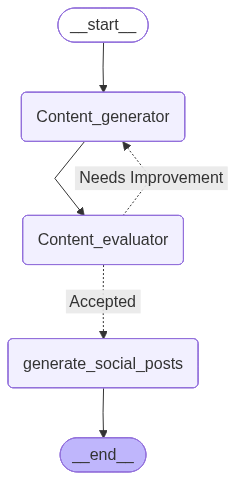

In [64]:
display(Image(workflow.get_graph().draw_mermaid_png()))

In [60]:
state = workflow.invoke({"topic": "How to cook chicken"})


In [61]:
print("\n Final Content:\n")
print(state["content"])
print("\n Feedback:", state["quality"], " ", state["feedback"] )


 Final Content:

## Mastering Chicken: Your Ultimate Guide to Delicious & Perfectly Cooked Poultry

Chicken is a culinary superstar – versatile, lean, affordable, and a fantastic canvas for countless flavors. But for many, cooking chicken can feel intimidating. Will it be dry? Is it cooked through?

Fear not, home chef! This guide will equip you with the knowledge and confidence to cook chicken that's juicy, flavorful, and perfectly safe every time.

---

### 1. Safety First: Handle with Care!

Before we even think about seasoning, let's talk food safety. Raw chicken can harbor bacteria, so proper handling is crucial.

*   **Wash Your Hands:** Always wash your hands thoroughly with soap and water before and after handling raw chicken.
*   **Separate Surfaces:** Use a dedicated cutting board for raw chicken, or wash it thoroughly with hot, soapy water (or run through a dishwasher) before using it for other foods.
*   **No Washing Chicken:** Contrary to popular belief, do *not* wash raw

In [62]:
print("\nFinal Multi-Platform Posts:\n")
print("X:", state["posts"]["X"])
print("LinkedIn:", state["posts"]["LinkedIn"])
print("Facebook:", state["posts"]["Facebook"])


Final Multi-Platform Posts:

X: Tired of dry chicken? 🍗 Master juicy, flavorful poultry every time! Our ultimate guide covers safety, prep, and key cooking methods to transform your kitchen. Say goodbye to guesswork! #ChickenTips #CookingHacks #HomeCooking
LinkedIn: Elevate your culinary skills with perfectly cooked chicken. This comprehensive guide offers insights into food safety protocols, optimal preparation techniques, and versatile cooking methods (pan-searing, roasting, grilling) to ensure consistently juicy and flavorful results. Invest in your kitchen confidence. #CulinarySkills #FoodSafety #KitchenEfficiency #CookingTips #ProfessionalCooking
Facebook: Ready to conquer chicken in your kitchen? 🐔✨ Our ultimate guide makes cooking delicious, juicy, and perfectly safe chicken a breeze! From essential safety tips to easy cooking methods like baking & grilling, you'll be a chicken master in no time. Get ready for happy meals! 🍽️ #HomeCooking #ChickenRecipes #FamilyMeals
